# Spirograph Documentation
Spirograph enables the creation of common climate data plots.

## Table of contents
1. Overview
2. User Guide
3. Extending spirograph
4. Functions

# 1. Overview

Spirograph is a dictionary-based function interface that wraps [Matplotlib](https://matplotlib.org/) and [Xarray](https://docs.xarray.dev/en/stable/) plotting functions to create common climate data plots. Its inputs are most commonly xarray DataArrays or Datasets, and it is best used when these arrays are the output of workflows incorporating [Xscen](https://github.com/Ouranosinc/xscen) and/or [Xclim](https://xclim.readthedocs.io/en/stable/). Style-wise, the plots follow the general guidelines offered by the [IPCC visual style guide 2022](https://www.ipcc.ch/site/assets/uploads/2022/09/IPCC_AR6_WGI_VisualStyleGuide_2022.pdf), but aim to create a look that could be distinctively associated with [Ouranos](https://www.ouranos.ca/en). The [Spirograph Github repository](https://github.com/Ouranosinc/spirograph) hosts the files needed to install the package, as well as the dependencies and requirements.

Spirograph currently includes the following functions:

1. **timeseries()**: Creates time series as line plots.
2. **gridmap()**: Plots gridded georeferenced data on a map.
3. **scattermap()**: Make a scatter plot of georeferenced data on a map.
4. **gdfmap()**: Plots geometries (through a GeoDataFrame) on a map.
5. **stripes()**: Create climate stripe diagrams.
6. **violin()**: Create seaborn violin plots with extra options.
7. **heatmap()**: Create seaborn heatmaps with extra options.

The following features are also included in the package:

* Automatically recognizes some common data structures (e.g. climate ensembles) using variable and coordinate names and creates the appropriate plots.
* Automatically links attributes from xarray objects to plot elements (title, axes), with customization options.
* Automatically assigns colors to some common variables and, following the IPCC visual guidelines.
* Provides options to visually enhance the plots, and includes a default style to ensure coherence when creating multiple plots.
* Returns a [matplotlib axes object](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html#matplotlib.axes.Axes) that is fully customizeable through matplotlib functions and methods.


# 2. User Guide

## Preparing the data

Spirograph only accepts [xarray DataArrays or Datasets](https://docs.xarray.dev/en/stable/user-guide/data-structures.html) as data inputs. As a general rule, spirograph functions will not accomplish any data processing or cleaning tasks - the object(s) passed to the functions should therefore only contain the data that will appear on the graph and the metadata that supports it.

To create, for instance, a time series plot from a NetCDF file, the following preparation steps have to be taken:

In [86]:
#import
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cartopy.crs as ccrs

import spirograph.matplotlib as sp

In [87]:
# create xarray object from a NetCDF
url = 'https://pavics.ouranos.ca//twitcher/ows/proxy/thredds/dodsC/birdhouse/disk2/cccs_portal/indices/Final/BCCAQv2_CMIP6/tx_max/YS/ssp585/ensemble_percentiles/tx_max_ann_BCCAQ2v2+ANUSPLIN300_historical+ssp585_1950-2100_30ymean_percentiles.nc'
opened = xr.open_dataset(url, decode_timedelta=False)

# select a location
ds_time = opened.isel(lon=500, lat=250)
# select only the variables containing the data to be plotted
ds_time = ds_time[['tx_max_p50', 'tx_max_p10', 'tx_max_p90']]

ds_time

<xarray.Dataset>
Dimensions:     (time: 13)
Coordinates:
    horizon     (time) |S64 ...
    lat         float64 61.87
    lon         float64 -99.29
  * time        (time) datetime64[ns] 1951-01-01 1961-01-01 ... 2071-01-01
Data variables:
    tx_max_p50  (time) float32 ...
    tx_max_p10  (time) float32 ...
    tx_max_p90  (time) float32 ...
Attributes: (12/28)
    ccdp_name:               tx_max
    description:             30 year mean Annual minimum of daily maximum tem...
    history:                 [2022-04-28 05:01:36] : Computation of the perce...
    long_name:               30 year mean Maximum daily maximum temperature
    standard_name:           air_temperature
    units:                   degC
    ...                      ...
    target_dataset:          ANUSPLIN interpolated Canada daily 300 arc secon...
    target_dataset_id:       ANUSPLIN300
    target_institute_id:     CFS-NRCan
    target_institution:      Canadian Forest Service, Natural Resources Canada
    target_references:       McKenney, D.W., Hutchinson, M.F., Papadopol, P.,...
    target_version:          obtained: 2 April 2012, 14 June 2012, and 30 Jan...

## Using the Ouranos matplotlib stylesheet

Most parameters affecting the style of plots can be set through matplotlib stylesheets. Spirograph includes custom stylesheets that can be accessed through the set_mpl_style() function. Paths to your own stylesheets ('.mplstyle' extension) can also be passed to this function. To use the built-in matplotlib styles, use `mpl.style.use()`.

The currently available stylesheets are as follows:

* ouranos: General stylesheet, including default colors.

In [88]:
# use ouranos style
sp.utils.set_mpl_style('ouranos')

#setup notebook
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}

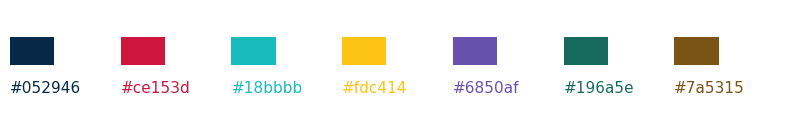

In [89]:
#display the cycler colors
from matplotlib.patches import Rectangle

style_colors = matplotlib.rcParams["axes.prop_cycle"].by_key()["color"]

fig, ax = plt.subplots(figsize=(10,3))
for color, x in zip(style_colors, np.arange(0, len(style_colors)*2, 2)):
    ax.add_patch(
    Rectangle(xy=(x, 1),width=0.8,height=0.5,
              facecolor=color)
    )
    ax.text(x, 0.5, str(color), color=color)

ax.set_ylim(0,2)
ax.set_xlim(0,14)
ax.set_aspect('equal')
ax.set_axis_off()

## Creating simple time series plots

The [**timeseries()**](#timeseries) function accepts DataArrays or Datasets. When only one object is passed to the function, using a dictionary is optional. Selecting one of the variables from our Dataset creates a DataArray (one line).

<Axes: title={'left': '30 year mean Annual minimum of daily maximum\ntemperature. 50th percentile of ensemble.'}, xlabel='time', ylabel='30 year mean Maximum daily\nmaximum temperature (K)'>

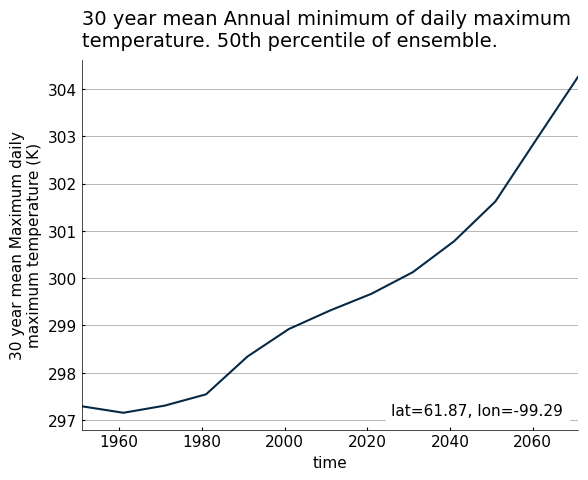

In [90]:
sp.timeseries(ds_time.tx_max_p50)

## Using the dictionary interface

The main elements of a plot are dependent on four arguments, each accepting dictionaries:

1. `data` : a dictionary containing the Xarray objects and their respective keys, used as labels on the plot.
2. `use_attrs`: a dictionary linking attributes from the Xarray object to plot text elements.
3. `fig_kw`: a dictionary to pass arguments to the `plt.figure()` instance.
4. `plot_kw` : a dictionary using the same keys as `data` to pass arguments to the underlying plotting function, in this case [matplotlib.axes.Axes.plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.plot.html).

When labels are passed in `data`, any 'label' argument passed in `plot_kw` will be ignored.

<Axes: title={'left': '30 year mean Annual minimum of daily maximum\ntemperature. 50th percentile of ensemble.'}, xlabel='time', ylabel='air_temperature (K)'>

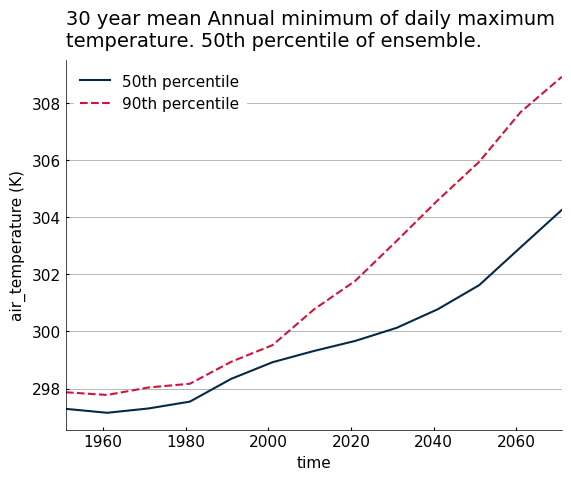

In [91]:
my_data = {'50th percentile': ds_time.tx_max_p50, '90th percentile': ds_time.tx_max_p90}
my_attrs = {'ylabel': 'standard_name'} # will look for an attribute 'standard name' in the first entry of my_data
plot_kws = {'90th percentile': {'linestyle': '--'}}

sp.timeseries(my_data,
              use_attrs = my_attrs,
              plot_kw = plot_kws,
              show_lat_lon=False
             )

## Customizing plots

Plots created with Spirograph can be customized in two different ways:

1. By using the built-in options through arguments (e.g. changing the type of legend with the `legend` arg).
2. By creating a Matplotlib Axes class and using its methods (e.g. setting a new title with `ax.set_title()`).

Both of these types of customization are demonstrated below. In some cases, both methods can achieve the same result.

<Axes: title={'left': 'Custom Title'}, xlabel='Custom xlabel', ylabel='Custom ylabel'>

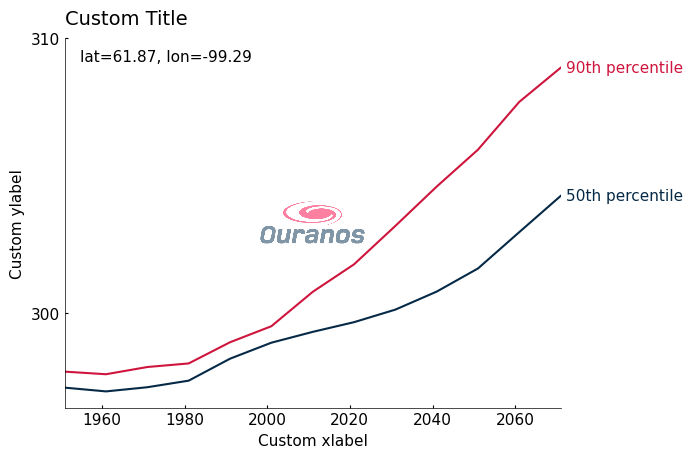

In [92]:
ax = sp.timeseries(my_data, show_lat_lon="upper left", legend='edge') # fun legend option, moved latitude and longitude tag
ax.set_title('Custom Title', loc='left') #when the title is left aligned, the "loc=left" argument must be used.
                                         # to remove a title, use ax.set_title('')
ax.set_xlabel('Custom xlabel')
ax.set_ylabel('Custom ylabel')
ax.grid(False) # removing the gridlines
ax.set_yticks([300,310]) # Custom yticks
sp.utils.plot_logo(ax, loc='center', offsetim_kw={'zoom': 0.15, 'alpha': 0.5})

## Line plots with Datasets

When Datasets are passed to the timeseries function, certain names and data configurations will be recognized and will result in certain kinds of plots.

| Dataset configuration | Resulting plot | Notes |
|:----------:|:--------------:|:----------------:|
|Variables contain a substring of the format "\_pNN", where N are numbers|Shaded line graph with the central line being the middle percentile|
|Contains a dimension named "percentiles"|Shaded line graph with the central line being the middle percentile| Behaviour is shared with DataArrays containing the same dimension.|
|Variables contain "min" and "max" and "mean" (can be capitalized) |Shaded line graph with the central line being the mean|
|Contains a dimension named "realization"|Line graph with one line per realization | When plot_kw is specified, all realizations within the Dataset will share one style.  Behaviour is shared with DataArrays containing the same dimension.|
|Any other Dataset| Line graph with one line per variable||



<Axes: title={'left': '30 year mean Annual minimum of daily maximum\ntemperature. 50th percentile of ensemble.'}, xlabel='time', ylabel='30 year mean Maximum daily\nmaximum temperature (K)'>

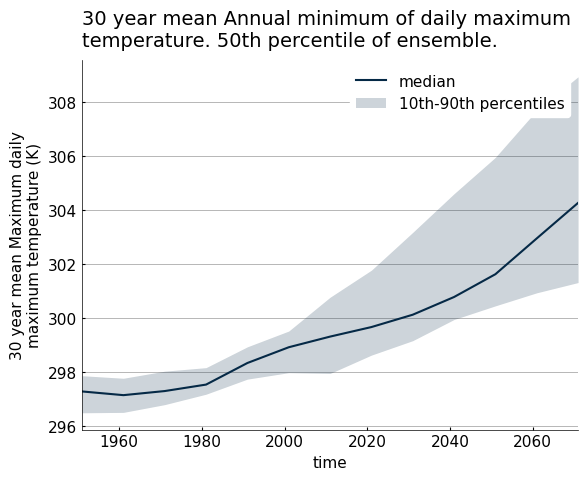

In [93]:
# Using 'median' as a key to make it the line label in the legend.
# legend='full' will create a legend entry for the shaded area
sp.plot.timeseries({'median': ds_time}, legend='full', show_lat_lon=False)

Whenever multiple lines are plotted from a single Dataset, their legend label will be the concatenation of the Dataset name (its key in the `data` arg.) and the name of the variables or coordinates from which the data is taken, unless the Dataset is passed to the function without a dictionary. When all lines from a Dataset have the same appearance, only the Dataset label will be shown.

<Axes: title={'left': '30 year mean Annual minimum of daily maximum\ntemperature. 50th percentile of ensemble.'}, xlabel='time', ylabel='30 year mean Maximum daily\nmaximum temperature (K)'>

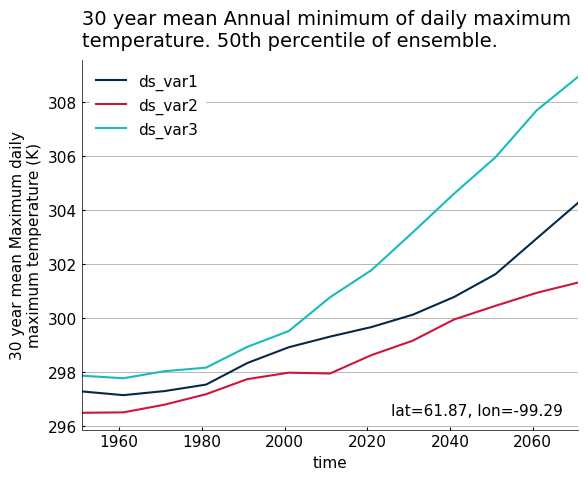

In [94]:
#Create a Dataset with different names as to not trigger the shaded line plot
ds_mod = ds_time.copy()
ds_mod = ds_mod.rename({'tx_max_p50': 'var1','tx_max_p10': 'var2','tx_max_p90': 'var3'})

sp.timeseries({'ds':ds_mod}, show_lat_lon=True)

## Keyword - color association

Following the IPCC visual style guidelines and the practices of many other climate organizations, some scenarios (RCPs, SSPs), models and projects (CMIPs) are associated with specific colors. These colors can be implemented in timeseries() through the keys of the `data` argument. If a formulation of such scenarios or model names is found in a key, the corresponding line will be given the appropriate color. For scenarios, alternative formats such as _ssp585_ or _rcp45_ are also accepted instead of the more formal _SSP5-8.5_ on _RCP4.5_. Model names do not currently have this flexibility. If multiple matching substrings exist, the following order of priority will dictate which color is used:

1. SSP scenarios
2. RCP scenarios
3. Model names
4. CMIP5 or CMIP6

A list of the accepted substrings and colors is shown below.

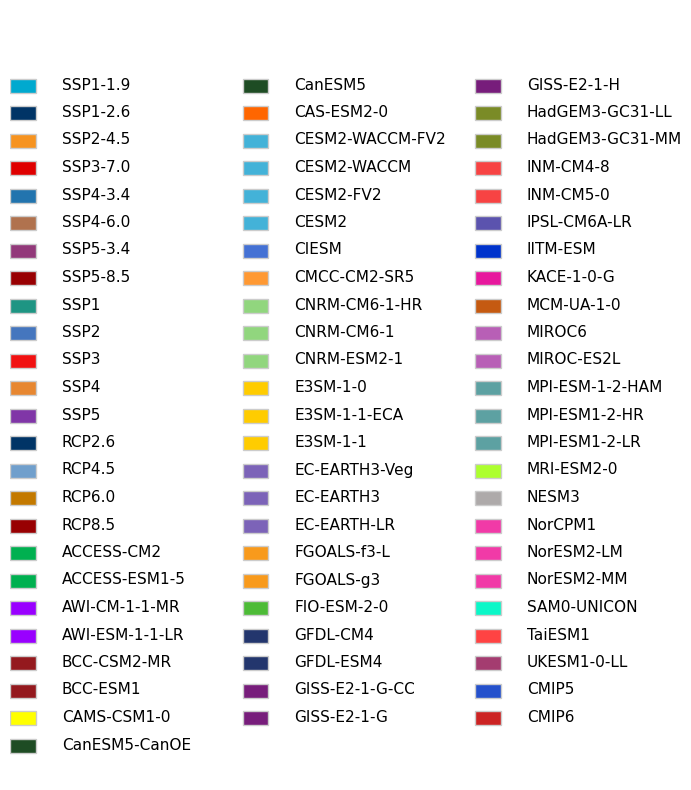

In [95]:
from matplotlib.patches import Rectangle

color_dict = sp.utils.categorical_colors()

keys = np.array(list(color_dict.keys()))
keys = np.array_split(keys, 3)


fig, ax = plt.subplots(figsize=(8,10))
ax.set_ylim(-25,3)
ax.set_xlim(0,12)
ax.set_axis_off()
for colorlist, x in zip(keys, [1, 5.5, 10]):
    for y in np.arange(len(colorlist)):
        ax.text(x, -y, colorlist[y],
                va='bottom', ha='left',
                backgroundcolor='white',
                weight='normal', color='k'
                )
        ax.add_patch(
            Rectangle(xy=(x-1, -y),width=0.5,height=0.5,
                      facecolor=color_dict[colorlist[y]],
                     edgecolor='0.8')
                     )

<Axes: title={'left': '30 year mean Annual minimum of daily maximum\ntemperature. 50th percentile of ensemble.'}, xlabel='time', ylabel='30 year mean Maximum daily\nmaximum temperature (K)'>

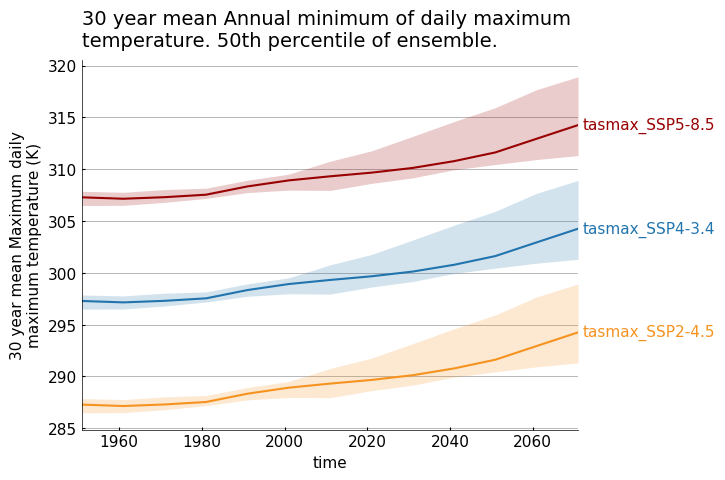

In [96]:
#creating fake scenarios
data = {'tasmax_ssp434': ds_time,
        'tasmax_ssp245': ds_time.copy()-10,
        'tasmax_ssp585': ds_time.copy()+10}

sp.timeseries(data=data, legend='edge', show_lat_lon=False)


# Plotting gridded data on maps

The [gridmap](#gridmap) function plots gridded data onto maps built using [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) along with xarray plotting functions. The main arguments of the timeseries() functions are also found in gridmap(), but new ones are introduced to handle map projections and colormap/colorbar options.

By default, the Lambert Conformal conic projection is used for the basemaps. The projection can be changed using the `projection` argument. The available projections [can be found here](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html#cartopy-projections). The `transform` argument should be used to specify the data coordinate system. If a transform is not provided, spirograph will look for dimensions named 'lat' and 'lon' or 'rlat' and 'rlon' and return the `ccrs.PlateCaree()` or `ccrs.RotatedPole()` transforms, respectively.

Features can also be added to the map by passing the names of the [cartopy pre-defined features](https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html) in a list via the `features` argument (case-insensitively). A nested dictionary can also be passed to `features` in order to apply modifiers to these features, for instance `features = {'coastline': {'scale': '50m', 'color':'grey'}}`.

The gridmap() function only accepts one object in its `data` argument, inside a dictionary or not. Datasets are accepted, but only their first variable will be plotted.

<GeoAxes: title={'center': '30 year mean Annual minimum\nof daily maximum temperature.\n50th percentile of ensemble.'}, xlabel='lon [degrees_east]', ylabel='lat [degrees_north]'>

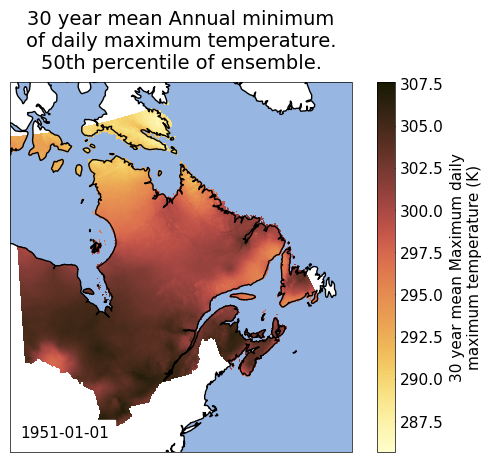

In [97]:
#Selecting a time and slicing our starting Dataset
ds_space = opened[['tx_max_p50']].isel(time=0).sel(lat=slice(40,65), lon=slice(-90,-55))

# defining our projection.
projection = ccrs.LambertConformal()

sp.gridmap(ds_space, projection = projection, features = ['coastline','ocean'], frame = True, show_time = 'lower left')

### Colormaps and colorbars

The colormap used to display the plots with gridmap() is directly dependent on three arguments:

* `cmap` accepts colormap objects or strings.

* `divergent` dictates whether or not the colormap will be sequential or divergent. If a number (integer of float) is provided, it becomes the center of the colormap. The default central value is 0.

* `levels=N` will create a discrete colormap of N levels. Otherwise, the colormap will be continuous.

 By default ( if `cmap=None`), spirograph will look for certain variable names in the attributes of the DataArray (`da.name` and `da.history`, in this order) and return a colormap corresponding to the 'group' of this variable, following the [IPCC visual style guide's scheme](https://www.ipcc.ch/site/assets/uploads/2022/09/IPCC_AR6_WGI_VisualStyleGuide_2022.pdf) (see page 11). The groups are displayed in the table below.

|Variable Group|Matching strings|
|:------------:|:--------------:|
| Temperature (temp)        | _tas, tasmin, tasmax, tdps, tg, tn, tx_|
|Precipitation (prec)        |_pr, prc, hurs, huss, rain,<br>precip, precipitation, humidity, evapotranspiration_|
|Wind (wind)        |_sfcWind, ua, uas, vas_|
|Cryosphere (cryo)        |_snw, snd, prsn, siconc, ice_|

Note: The strings shown above will not be recognized as variables if they are part of a longer word, for example 'tas' in 'fantastic'.

The colormaps are built from RGB data be found in the [IPCC-WG1 Github repository](https://github.com/IPCC-WG1/colormaps). When none of the variables names match a group, or when multiple matches are found, the function resorts to the ['Batlow' colormap](https://www.fabiocrameri.ch/batlow/).

Strings passed to these arguments can either be names of matplotlib colormaps or names of the IPCC-prescribed colormaps, such as 'temp_div'(divergent colormap for temperature variables) or 'prec_seq.txt' (sequential colormap for precipitation-related variables).Any colormap specified as a string can be reversed by adding '_r' to the end of the string.


Text(0.5, 1.0, "This is still temperature data,\nbut let's pretend.")

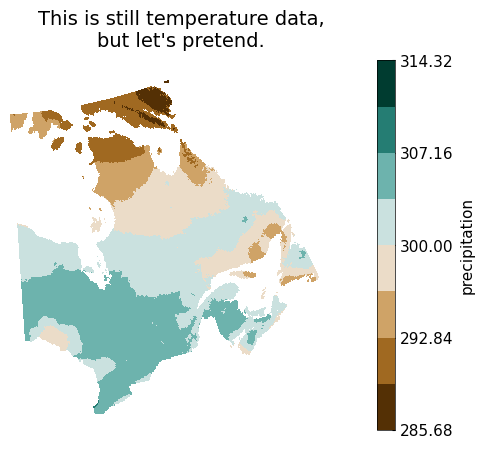

In [98]:
#change the name of our DataArray for one that inclues 'pr' (precipitation) - this is still the same temperature data
da_pr = ds_space.tx_max_p50.copy()
da_pr.name = 'pr_max_p50'

#diverging colormap with 8 levels, centered at 300
ax = sp.gridmap(da_pr, projection=projection, divergent=300, levels=8, plot_kw={'cbar_kwargs':{'label':'precipitation'}})
ax.set_title('This is still temperature data,\nbut let\'s pretend.')

**Note**: Using the `levels` argument will result in a colormap that is split evenly across the span of the data, without consideration for how 'nice' the intervals are (i.e. the boundaries of the different colors will often fall on numbers with some decimals, that might be totally significant to an audience). To obtain 'nice' intervals, it is possible to use the `levels` argument in `plot_kw`. This might however, and often, result in the number of levels not being exactly the one that is specified. Using both arguments is not recommended.

Text(0.5, 1.0, "This cmap has 6 levels instead of 8,\nbut aren't they nice?")

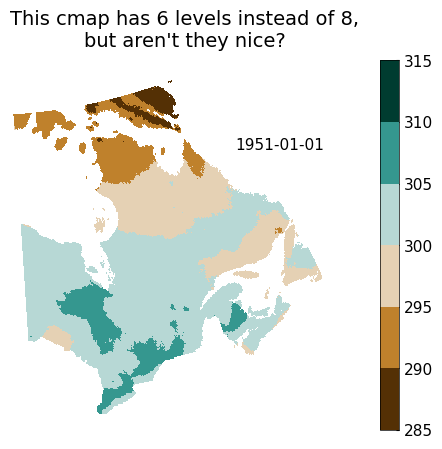

In [99]:
#creating the same map, with 'nice' levels.
ax = sp.gridmap(da_pr, projection=projection, divergent=300, plot_kw={'levels':8, 'cbar_kwargs':{'label':None}}, show_time=(0.65, 0.75))
ax.set_title('This cmap has 6 levels instead of 8,\nbut aren\'t they nice?')

It is also possible to specify your own levels by passing a list to `plot_kw['levels'].

<GeoAxes: title={'center': 'Custom levels'}, xlabel='lon [degrees_east]', ylabel='lat [degrees_north]'>

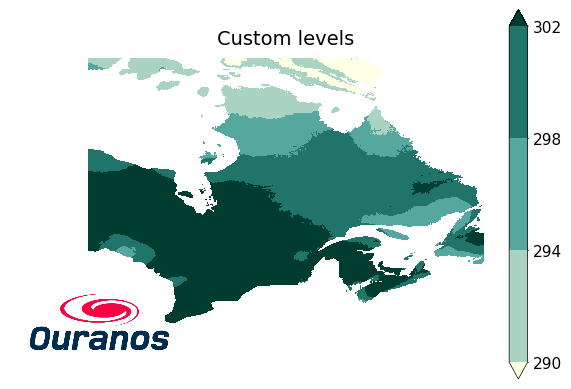

In [100]:
ax = sp.plot.gridmap(da_pr, plot_kw={'levels':[290,294,298,302], 'cbar_kwargs':{'label':None}})
ax.set_title('Custom levels')
sp.utils.plot_logo(ax, loc='lower left')

### pcolormesh vs contourf

By default, xarray plots two-dimensional DataArrays using the matplotlib pcolormesh function (see [xarray.plot.pcolormesh](https://docs.xarray.dev/en/stable/generated/xarray.plot.pcolormesh.html#xarray.plot.pcolormesh)). The `contourf` argument in gridmap allows the user to use [xarray.plot.contourf](https://docs.xarray.dev/en/stable/generated/xarray.plot.contourf.html?highlight=xarray.plot.contourf) function instead. This also implies the key-value pairs passed in `plot_kw` are passed to these functions.

At a large scales, both of these functions create practically equivalent plots. However, their inner workings are inheritely different, and these different ways of plotting data become apparent at small scales.

When using contourf, passing a value in `levels` is equivalent to passing it in `plot_kw['levels']`, meaning the number of levels on the plot might not be exactly the specified value.

Text(0.5, 1.0, 'contourf')

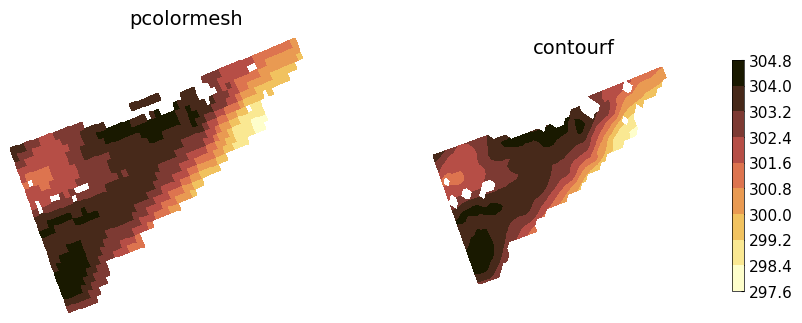

In [101]:
zoomed = ds_space['tx_max_p50'].sel(lat=slice(44,46), lon=slice(-65,-60))

fig, axs = plt.subplots(1,2, figsize=(10,6), subplot_kw= {'projection': ccrs.LambertConformal()})
sp.gridmap(ax = axs[0], data=zoomed, contourf=False,plot_kw={'levels':10, 'add_colorbar':False})
axs[0].set_title('pcolormesh')
sp.gridmap(ax = axs[1],data=zoomed, contourf=True, plot_kw={'levels':10, 'cbar_kwargs':{'shrink':0.5, 'label':None}})
axs[1].set_title('contourf')

# Plotting station data on maps

Data that is georeferenced by coordinates (e.g. latitude and longitude) but is not on a grid can be plotted using the [scattermap](#gridmap) function. This function is practically identical to `gridmap()`, but introduces some new arguments (see examples below). The function essentially builds a basemap using cartopy and calls `plt.scatter()` to plot the data.

/home/sarbou1/PycharmProjects/spirograph/spirograph/matplotlib/utils.py:156: UserWarning: Attribute "description" not found.
  warnings.warn(f'Attribute "{string}" not found.')


(43.0, 50.0)

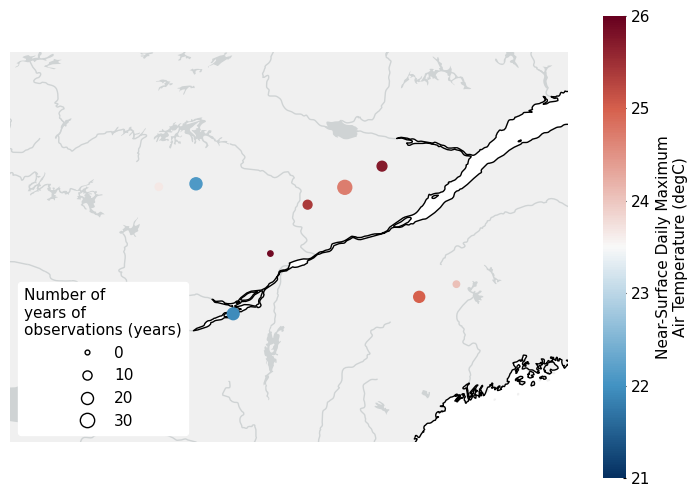

In [102]:
# create a fictional observational dataset from scratch
names = ['station_' + str(i) for i in np.arange(10)]
lat = 45 + np.random.rand(10)*3
lon = np.linspace(-76,-70, 10)
tas = 20 + np.random.rand(10)*7
yrs = (30 * np.random.rand(10)).astype(int)
attrs = {'units': 'degC', 'standard_name': 'air_temperature', 'long_name': 'Near-Surface Daily Maximum Air Temperature'}

tas = xr.DataArray(data=tas,
                        coords={'station': names, 'lat':('station', lat), 'lon': ('station', lon)},
                        dims=['station'],
                        attrs=attrs)
years = tas.copy().assign_attrs({'long_name': "Number of years of observations", 'units': 'years'})

years.data = yrs

obs = xr.Dataset({'tas': tas, 'years': years})

#set nice features
features = {"land": {"color": "#f0f0f0"},
            "rivers": {"edgecolor": "#cfd3d4"},
            "lakes": {"facecolor": "#cfd3d4"},
            "coastline": {"edgecolor": "black"},
}

# plot
ax =sp.scattermap(obs,
                  transform=ccrs.PlateCarree(),
                  sizes='years',
                  size_range=(15, 100),
                  divergent=23.5,
                  features=features,
                  fig_kw={'figsize': (9,6)},
                  legend_kw={'loc': 'lower left'},
                 )
ax.set_xlim(-78,-68)
ax.set_ylim(43,50)


It is possible to plot observations on top of gridded data by calling both `gridmap()` and `scattermap()` and fixing the colormap limits (`vmin` and `vmax`), like demonstrated below.

/home/sarbou1/PycharmProjects/spirograph/spirograph/matplotlib/utils.py:156: UserWarning: Attribute "description" not found.
  warnings.warn(f'Attribute "{string}" not found.')


<GeoAxes: xlabel='lon [degrees_east]', ylabel='lat [degrees_north]'>

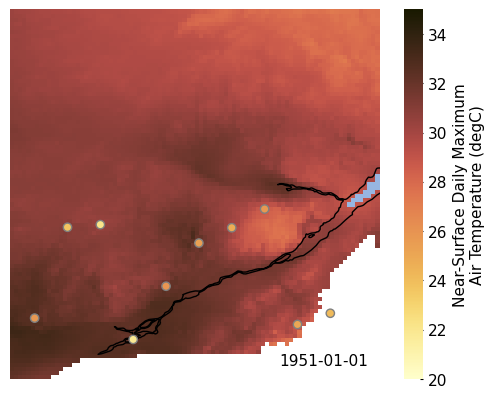

In [103]:
# defining our limits
vmin= 20
vmax= 35

# plotting the gridded data
ax = sp.gridmap(ds_space-273.15,
                plot_kw={'vmin': vmin, 'vmax': vmax, 'add_colorbar': False},
                features=['coastline','ocean'],
                show_time='lower right'
               )
ax.set_extent([-76.5, -69, 44.5, 52], crs=ccrs.PlateCarree()) # equivalent to set_xlim and set_ylim for projections

# plotting the observations
sp.scattermap(obs,
              ax=ax,
              transform=ccrs.PlateCarree(),
              plot_kw={'vmin': vmin, 'vmax': vmax, 'edgecolors':'grey'}
             )

# Plotting geometries

The [gdfmap](#gdfmap) function plots geometries contained in a GeoPandas [GeoDataFrame](https://geopandas.org/en/stable/docs/user_guide/data_structures.html#geodataframe) on maps. It is a thin wrap around the [GeoDataFrame.plot()](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot) method, with verys similar functionality to `gridmap()` and most of the same features.

To use this function, the data to be linked to the colormap has to be included in the GeoDataFrame. Its name (as a string) must be passed to the `df_col` argument. Like described above, if the `cmap` argument is `None`, the function will look for common variable names in the name of this column, and use an appropriate colormap if a match is found.

Text(0.5, 1.0, 'Southern Quebec Watersheds')

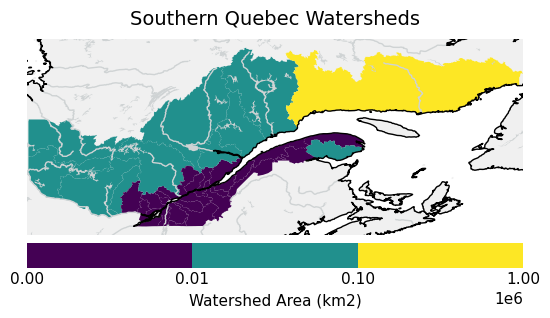

In [104]:
import geopandas as gpd

wsheds = gpd.read_file('https://stqc380donopppdtce01.blob.core.windows.net/donnees-ouvertes/Zones_gestion_integree_eau/ZGIEBV.json ')

ax = sp.gdfmap(wsheds,
          'ZGIE_KM2',
          cmap = 'viridis',
          levels = [0,10000,100000,1000000],
          plot_kw = {'legend_kwds': {'label': 'Watershed Area (km2)'}}
                )

ax.set_title('Southern Quebec Watersheds')

Projections can be used like in `gridmap()`, although some of the Cartopy projections might lead to unexpected results due to the interaction between Cartopy and GeoPandas, especially when the whole globe is plotted.

Also note that the colorbar parameters have to be accessed through the `legend_kwds` argument of [GeoDataFrame.plot()](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot).

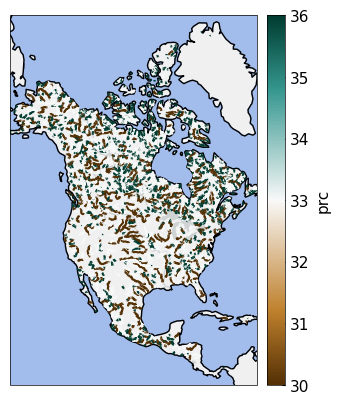

In [105]:
rivers = gpd.read_file('https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_10m_rivers_north_america.geojson')

#create a fake variable 'prc'
rivers['prc'] = rivers['scalerank'] * 3

ax = sp.gdfmap(rivers,
               'prc',
               projection = ccrs.LambertConformal(),
               features = {'ocean': {'color':'#a2bdeb'}},
               plot_kw = {'legend_kwds':{'orientation': 'vertical'}},
               divergent=True,
               frame=True
              )

## Creating climate stripes

Climate stripe diagrams are a way to present the relative change of climate variables or indicators over time, in a simple and aesthetically-oriented manner. Spirograph creates such plots through the [stripes()](#stripes) function.

While the vast majority of these diagrams will show the yearly change of a variable relative to a reference point, `stripes()` will adjust the size of the stripes to fill the figure to accomodate datasets with time intervals greater than a year.

The function accepts DataArrays, one-variable Datasets, and a dictionary containing scenarios (DataArrays or Datasets) to be stacked. The plot will be divided in as many sub-axes as there are entries in the dictionary. Normally, these scenarios would contain identical data up to a certain year, where the scenarios diverge; the `divide` argument should be used to create an axis separation at this point of divergence.

<Axes: >

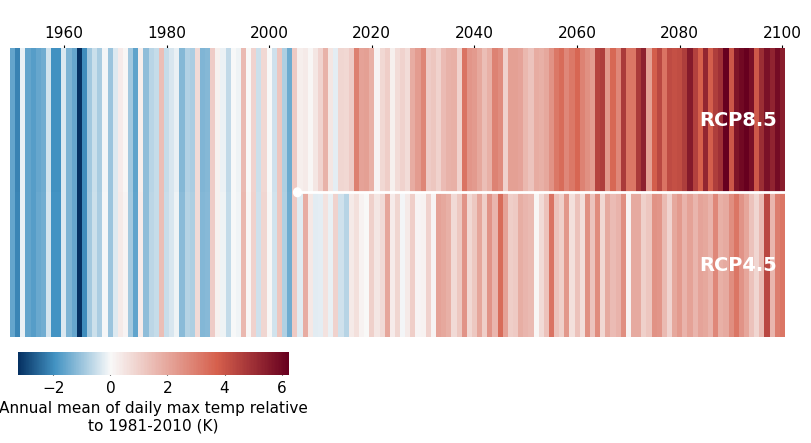

In [106]:
# create two datasets of mean annual temperature relative to the 1981-2010 period
url1 = 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/disk2/ouranos/portraits-clim-1.3/MPI-ESM-LR_rcp85_tx_mean_annual.nc'
rcp85 = xr.open_dataset(url1, decode_timedelta=False)
rcp85 = rcp85.sel(lon=-73, lat=46, method='nearest')
rcp85_deltas = rcp85 - rcp85.sel(time=slice("1981","2010")).mean(dim='time')
rcp85_deltas.tx_mean_annual.attrs['long_name'] = 'Mean annual daily max temp relative to 1981-2010'
rcp85_deltas.tx_mean_annual.attrs['units'] = 'K'

url2 = 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/disk2/ouranos/portraits-clim-1.3/MPI-ESM-LR_rcp45_tx_mean_annual.nc'
rcp45 = xr.open_dataset(url2, decode_timedelta=False)
rcp45 = rcp45.sel(lon=-73, lat=46, method='nearest')
rcp45_deltas = rcp45 - rcp45.sel(time=slice("1981","2010")).mean(dim='time')
rcp45_deltas.tx_mean_annual.attrs['long_name'] = 'Annual mean of daily max temp relative to 1981-2010'
rcp45_deltas.tx_mean_annual.attrs['units'] = 'K'

# plot
sp.stripes({'rcp45': rcp45_deltas, 'rcp85': rcp85_deltas}, divide=2006)

Like most of the other functions, `stripes()` will attempt to find a colormap that is appropriate for the data variables.

Text(0.5, 1.0, 'Precipitation')

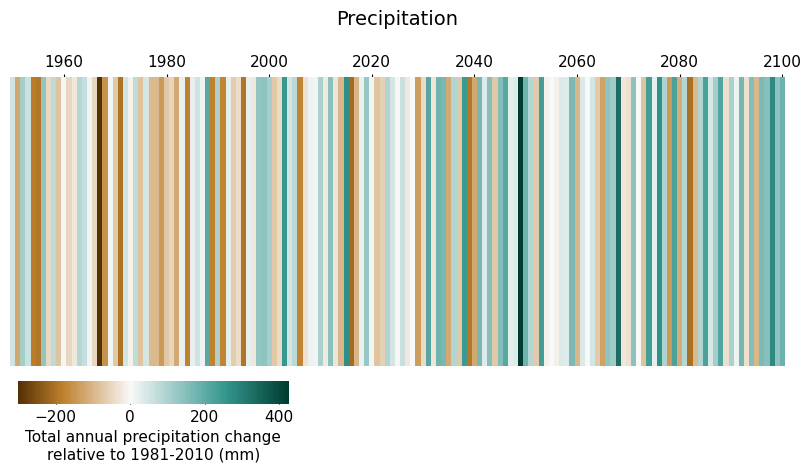

In [107]:
# creating a similar dataset with precipitation data
url3 = 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/disk2/ouranos/portraits-clim-1.3/MPI-ESM-LR_rcp85_precip_accumulation_annual.nc'
prec = xr.open_dataset(url3, decode_timedelta=False)
prec = prec.sel(lon=-73, lat=46, method='nearest')
prec_deltas = prec - prec.sel(time=slice("1981","2010")).mean(dim='time')
prec_deltas.precip_accumulation_annual.attrs['long_name'] = 'Total annual precipitation change relative to 1981-2010'
prec_deltas.precip_accumulation_annual.attrs['units'] = 'mm'

ax = sp.stripes(prec_deltas)
ax.set_title('Precipitation')

# Violin plots

Violin plots are a practical tool for visualizing the statistical distribution of data in an ensemble, combining a box plot with a kernel density plot. The [violin](#violin) function wraps Seaborn's [violinplot](https://seaborn.pydata.org/generated/seaborn.violinplot.html#seaborn.violinplot) function to directly accept xarray objects, and incorporates other spirograph features. The `data` argument can be a DataArray (one "violin"), a Dataset (as many "violins" as there are variables in the Dataset), or a dictionary of either types. In the case of a dictionary, its keys will become the "violin" labels.

As with other functions, when `use_attrs` is passed and `data` is a dictionary, attributes from the first dictionary entry will be put on the plot.

<Axes: title={'left': '30 year mean Annual minimum of daily maximum\ntemperature. 50th percentile of ensemble.'}, ylabel='30 year mean Maximum daily\nmaximum temperature (K)'>

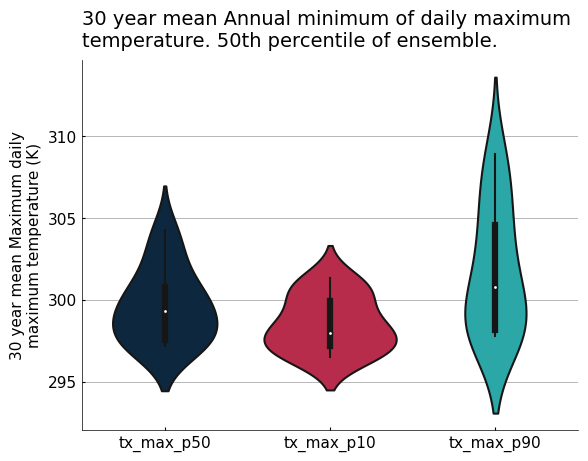

In [108]:
sp.violin(ds_time, use_attrs={'title':'description'})

The optional `color` argument combines the Seaborn function's `color` and `palette` arguments. A single color or a list of colors can be passed. Integers can be passed instead of strings to refer to colors of the currently used stylesheet. If the list of colors is shorter than the number of variables on the plot, the colors are repeated.

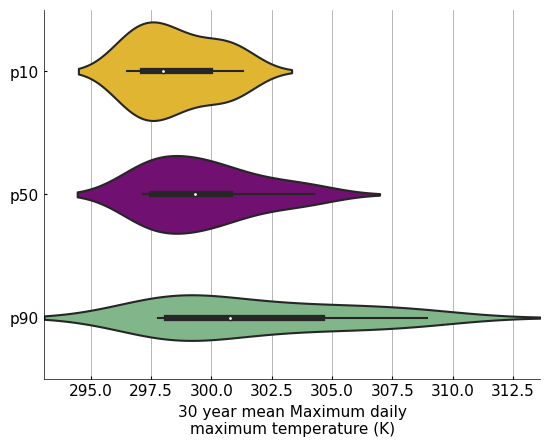

In [109]:
my_data = {'p10': ds_time.tx_max_p10,'p50': ds_time.tx_max_p50, 'p90': ds_time.tx_max_p90}

ax = sp.violin(my_data, plot_kw={'orient':'h'}, color=[3, 'purple', '#78bf84'])

# Heatmaps

Similarly to violin plots, the [heatmap](#heatmap) function wraps Seaborn's [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function to directly accept xarray objects, and incorporates other spirograph features. The `data` argument can be a DataArray, a Dataset, or a dictionary of either types and of length=1. There is no real benefit to using a dictionary, but it is accepted to be coherent with other functions in the package.

<Axes: xlabel='properties', ylabel='realization'>

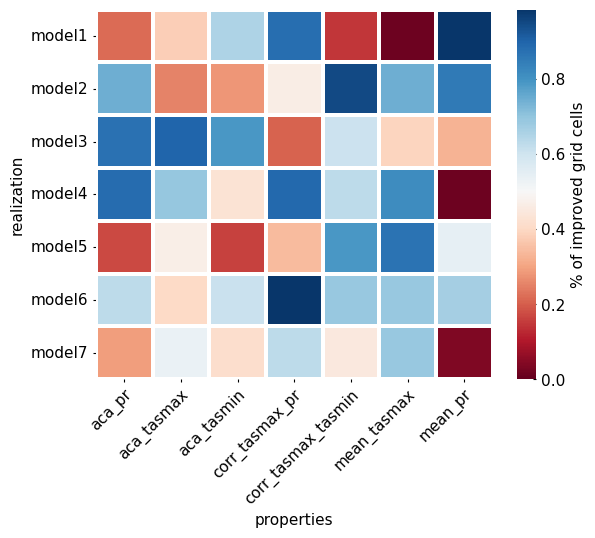

In [110]:
# create diagnostics Dataset from scratch

improvement = np.random.rand(7,7)
diagnostics = xr.DataArray(data=improvement,
                           coords=dict(realization=['model1', 'model2', 'model3', 'model4', 'model5', 'model6', 'model7'],
                                       properties=['aca_pr', 'aca_tasmax', 'aca_tasmin', 'corr_tasmax_pr',
                                                   'corr_tasmax_tasmin', 'mean_tasmax', 'mean_pr']))

diagnostics.attrs['long_name'] = "% of improved grid cells"

# plot heatmap

sp.heatmap(diagnostics, divergent=0.5, plot_kw={'vmin': 0, 'linecolor': 'w', 'linewidth':1.5})


In order to produce realiable results, the xarray object passed to `heatmap()` has to have only two dimensions. Under the hood, the function converts the DataArray containing the data to a pandas DataFrame before plotting it. Using `transpose=True` swaps the x and y axes.

The colorbar kwargs are accessible through the nesting of `cbar_kws` in `plot_kw`.

Text(53.380208333333314, 0.5, '')

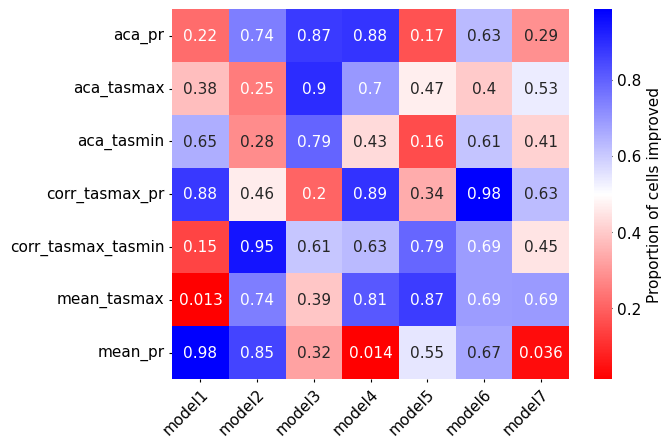

In [111]:

ax = sp.heatmap(diagnostics,
                transpose=True,
                cmap='bwr_r',
                divergent=0.5,
                plot_kw={'cbar_kws':{'label': 'Proportion of cells improved'}, 'annot':True}
               )
ax.set_xlabel("") # get rid of labels
ax.set_ylabel("")

# 4. Functions

<a id='timeseries'></a>
## timeseries()

In [112]:
print(sp.timeseries.__doc__)

Plot time series from 1D Xarray Datasets or DataArrays as line plots.

    Parameters
    ----------
    data : dict or Dataset/DataArray
        Input data to plot. It can be a DataArray, Dataset or a dictionary of DataArrays and/or Datasets.
    ax : matplotlib.axes.Axes, optional
        Matplotlib axis on which to plot.
    use_attrs : dict, optional
        A dict linking a plot element (key, e.g. 'title') to a DataArray attribute (value, e.g. 'Description').
        Default value is {'title': 'description', 'ylabel': 'long_name', 'yunits': 'units'}.
        Only the keys found in the default dict can be used.
    fig_kw : dict, optional
        Arguments to pass to `plt.subplots()`. Only works if `ax` is not provided.
    plot_kw : dict, optional
        Arguments to pass to the `plot()` function. Changes how the line looks.
        If 'data' is a dictionary, must be a nested dictionary with the same keys as 'data'.
    legend : str (default 'lines')
        'full' (lines and sha

<a id='gridmap'></a>
## gridmap()

In [113]:
print(sp.gridmap.__doc__)

Create map from 2D data.

    Parameters
    ----------
    data : dict, DataArray or Dataset
        Input data do plot. If dictionary, must have only one entry.
    ax : matplotlib axis, optional
        Matplotlib axis on which to plot, with the same projection as the one specified.
    use_attrs : dict, optional
        Dict linking a plot element (key, e.g. 'title') to a DataArray attribute (value, e.g. 'Description').
        Default value is {'title': 'description', 'cbar_label': 'long_name', 'cbar_units': 'units'}.
        Only the keys found in the default dict can be used.
    fig_kw : dict, optional
        Arguments to pass to `plt.figure()`.
    plot_kw:  dict, optional
        Arguments to pass to the `xarray.plot.pcolormesh()` or 'xarray.plot.contourf()' function.
        If 'data' is a dictionary, can be a nested dictionary with the same keys as 'data'.
    projection : ccrs.Projection
        The projection to use, taken from the cartopy.crs options. Ignored if ax is n

<a id='scattermap'></a>
## scattermap()

In [114]:
print(sp.scattermap.__doc__)

Make a scatter plot of georeferenced data on a map.

    Parameters
    ----------
    data : dict, DataArray or Dataset
        Input data do plot. If dictionary, must have only one entry.
        If a Dataset with multiple variables, the first one will be plotted against the colormap.
    ax : matplotlib axis, optional
        Matplotlib axis on which to plot, with the same projection as the one specified.
    use_attrs : dict, optional
        Dict linking a plot element (key, e.g. 'title') to a DataArray attribute (value, e.g. 'Description').
        Default value is {'title': 'description', 'cbar_label': 'long_name', 'cbar_units': 'units'}.
        Only the keys found in the default dict can be used.
    fig_kw : dict, optional
        Arguments to pass to `plt.figure()`.
    plot_kw :  dict, optional
        Arguments to pass to `plt.scatter()`.
        If 'data' is a dictionary, can be a dictionary with the same key as 'data'.
    projection : ccrs.Projection
        The project

<a id='gdfmap'></a>
## gdfmap()

In [115]:
print(sp.gdfmap.__doc__)


    Create a map plot from geometries.

    Parameters
    ----------
    df : geopandas.GeoDataFrame
        Dataframe containing the geometries and the data to plot. Must have a column named 'geometry'.
    df_col : str
        Name of the column of 'df' containing the data to plot using the colorscale.
    ax : cartopy.mpl.geoaxes.GeoAxes or cartopy.mpl.geoaxes.GeoaxesSubplot, optional
        Matplotlib axis built with a projection, on which to plot.
    fig_kw : dict, optional
        Arguments to pass to `plt.figure()`.
    plot_kw :  dict, optional
        Arguments to pass to the GeoDataFrame.plot() method.
    projection : ccrs.Projection
        The projection to use, taken from the cartopy.crs options.
    features : list or dict, optional
        Features to use, as a list or a nested dict containing kwargs. Options are the predefined features from
        cartopy.feature: ['coastline', 'borders', 'lakes', 'land', 'ocean', 'rivers', 'states'].
    cmap : matplotlib.colors.

<a id='stripes'></a>
## stripes()

In [116]:
print(sp.stripes.__doc__)


    Create stripes plot with or without multiple scenarios.

    Parameters
    ----------
    data : dict or DataArray or Dataset
        Data to plot. If a dictionary of xarray objects, each will correspond to a scenario.
    ax : matplotlib.axes.Axes, optional
        Matplotlib axis on which to plot.
    fig_kw : : dict, optional
        Arguments to pass to `plt.subplots()`. Only works if `ax` is not provided.
    divide : int, optional
        Year at which the plot is divided into scenarios. If not provided, the horizontal separators
        will extent over the full time axis.
    cmap : matplotlib.colors.Colormap or str, optional
        Colormap to use. If str, can be a matplotlib or name of the file of an IPCC colormap (see data/ipcc_colors).
        If None, look for common variables (from data/ipcc_colors/varaibles_groups.json) in the name of the DataArray
        or its 'history' attribute and use corresponding diverging colormap, aligned with the IPCC visual style guide

<a id='violin'></a>
## violin()

In [117]:
print(sp.violin.__doc__)

Make violin plot using seaborn.

    Parameters
    ----------
    data : dict or Dataset/DataArray
        Input data to plot. If a dict, must contain DataArrays and/or Datasets.
    ax : matplotlib.axes.Axes, optional
        Matplotlib axis on which to plot.
    use_attrs : dict, optional
        A dict linking a plot element (key, e.g. 'title') to a DataArray attribute (value, e.g. 'Description').
        Default value is {'title': 'description', 'ylabel': 'long_name', 'yunits': 'units'}.
        Only the keys found in the default dict can be used.
    fig_kw : dict, optional
        Arguments to pass to `plt.subplots()`. Only works if `ax` is not provided.
    plot_kw : dict, optional
        Arguments to pass to the `seaborn.violinplot()` function.
    color :  str, int or list, optional
        Unique color or list of colors to use. Integers point to the applied stylesheet's colors, in zero-indexed order.
        Passing 'color' or 'palette' in plot_kw overrides this argument.



<a id='heatmap'></a>
## heatmap()

In [118]:
print(sp.heatmap.__doc__)


Create heatmap from a DataArray.

    Parameters
    ----------
    data : dict or DataArray or Dataset
        Input data do plot. If dictionary, must have only one entry.
    ax : matplotlib axis, optional
        Matplotlib axis on which to plot, with the same projection as the one specified.
    use_attrs : dict, optional
        Dict linking a plot element (key, e.g. 'title') to a DataArray attribute (value, e.g. 'Description').
        Default value is {'cbar_label': 'long_name'}.
        Only the keys found in the default dict can be used.
    fig_kw : dict, optional
        Arguments to pass to `plt.figure()`.
    plot_kw :  dict, optional
        Arguments to pass to the 'seaborn.heatmap()' function.
        If 'data' is a dictionary, can be a nested dictionary with the same key as 'data'.
    transpose : bool
        If true, the 2D data will be transposed, so that the original x-axis becomes the y-axis and vice versa.
    cmap : matplotlib.colors.Colormap or str, optional
  